This notebook shows how we computed the R2 scores for all ensembles and individual models

In [1]:

from tensorflow.keras.layers import Input, Dense, Concatenate
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
import torch as to


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps



original_dim_input=109  # CBRAIN input node size

original_dim_output=int(112) # CBRAIN output node size 
original_dim_output_VED=int(113) # CBRAIN output node size for VEDs 


# network parameters
input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 405

batch_size = 3551

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

out_vars_VED = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']


#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values




# defining the scaling dict for the VAE training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}







from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai


PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];
import torch.nn as nn
import torch.nn.functional as F

2024-01-31 14:48:26.261940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#load test data

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [3]:
#load test data for VED networks 
val_gen_III = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars_VED,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

# Load pytorch models 

In [4]:
#load ANN networks 
ANN_1_lin=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_CRM_lin_jit.pt')
ANN_2_lin=to.jit.load('real_geography/ANNs/ANN_2/ANN_2_CRM_lin_jit.pt')
ANN_3_lin=to.jit.load('real_geography/ANNs/ANN_3/ANN_3_CRM_lin_jit.pt')
ANN_4_lin=to.jit.load('real_geography/ANNs/ANN_4/ANN_4_CRM_lin_jit.pt')
ANN_5_lin=to.jit.load('real_geography/ANNs/ANN_5/ANN_5_CRM_lin_jit.pt')
ANN_6_lin=to.jit.load('real_geography/ANNs/ANN_6/ANN_6_CRM_lin_jit.pt')
ANN_7_lin=to.jit.load('real_geography/ANNs/ANN_7/ANN_7_CRM_lin_jit.pt')



In [5]:
# load VED networks 

VEnc_1=to.jit.load('real_geography/VEDs/VED_1/VEncoder_1_torch_jit.pt')
VDec_1=to.jit.load('real_geography/VEDs/VED_1/VDecoder_1_torch_jit.pt')
VEnc_2=to.jit.load('real_geography/VEDs/VED_2/VEncoder_2_torch_jit.pt')
VDec_2=to.jit.load('real_geography/VEDs/VED_2/VDecoder_2_torch_jit.pt')
VEnc_3=to.jit.load('real_geography/VEDs/VED_3/VEncoder_3_torch_jit.pt')
VDec_3=to.jit.load('real_geography/VEDs/VED_3/VDecoder_3_torch_jit.pt')
VEnc_4=to.jit.load('real_geography/VEDs/VED_4/VEncoder_4_torch_jit.pt')
VDec_4=to.jit.load('real_geography/VEDs/VED_4/VDecoder_4_torch_jit.pt')
VEnc_5=to.jit.load('real_geography/VEDs/VED_5/VEncoder_5_torch_jit.pt')
VDec_5=to.jit.load('real_geography/VEDs/VED_5/VDecoder_5_torch_jit.pt')
VEnc_7=to.jit.load('real_geography/VEDs/VED_7/VEncoder_7_torch_jit.pt')
VDec_7=to.jit.load('real_geography/VEDs/VED_7/VDecoder_7_torch_jit.pt')



In [6]:
# load ANN1 with dropout
ANN_1_lin_dr_01=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_lin_dr_out_0_01_torch_jit.pt')


# Compute R² scores 

In [7]:
def R_2_calc_ens_lin(data_set,number_of_networks,stoch_ensemble):
    """
    compute R² scores for stochastic and deterministic multi-ANN ensembles 
    author: G.Behrens
    """
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    R_2_1=np.nan*np.zeros((int(96*144),original_dim_output))
    ens=np.zeros((number_of_networks,int(96*144),original_dim_output))
    
    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        ens[0,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[1,:,:]=data_set.output_transform.inverse_transform(ANN_2_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[2,:,:]=data_set.output_transform.inverse_transform(ANN_3_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[3,:,:]=data_set.output_transform.inverse_transform(ANN_4_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[4,:,:]=data_set.output_transform.inverse_transform(ANN_5_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[5,:,:]=data_set.output_transform.inverse_transform(ANN_6_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[6,:,:]=data_set.output_transform.inverse_transform(ANN_7_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        R_2_1[k]=1-np.nanmean((np.squeeze(true[:,k,:])-np.squeeze(pred[:,k,:]))**2,0)/np.nanvar(np.squeeze(true[:,k,:]),0)
    del pred, true,ens
    return R_2_1

In [ ]:
deter_7_lin_r_2=R_2_calc_ens_lin(val_gen_II,7,7)
#np.save('R_2_real_geo/deter_7_lin_r_2',deter_7_lin_r_2)


In [ ]:
stoch_5_lin_r_2=R_2_calc_ens_lin(val_gen_II,7,5)
#np.save('R_2_real_geo/stoch_5_lin_r_2',stoch_5_lin_r_2)


In [8]:
def R_2_calc_ens_VED_ori(data_set,number_of_networks,stoch_ensemble):
    """
    compute R² scores for multi-VED ensemble 
    author: G.Behrens
    """
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    R_2_1=np.nan*np.zeros((int(96*144),113))
    ens=np.zeros((number_of_networks,int(96*144),113))
    
    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        ens[0,:,:]=data_set.output_transform.inverse_transform(VDec_1(VEnc_1((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[1,:,:]=data_set.output_transform.inverse_transform(VDec_2(VEnc_2((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[2,:,:]=data_set.output_transform.inverse_transform(VDec_3(VEnc_3((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[3,:,:]=data_set.output_transform.inverse_transform(VDec_4(VEnc_4((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[4,:,:]=data_set.output_transform.inverse_transform(VDec_5(VEnc_5((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[5,:,:]=data_set.output_transform.inverse_transform(VDec_7(VEnc_7((to.from_numpy(data_set[i][0])))).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        R_2_1[k]=1-np.nanmean((np.squeeze(true[:,k,:])-np.squeeze(pred[:,k,:]))**2,0)/np.nanvar(np.squeeze(true[:,k,:]),0)
    del pred, true,ens
    return R_2_1

In [ ]:
VED_R_2_ens_6_ori=R_2_calc_ens_VED_ori(val_gen_III,6,6)
#np.save('R_2_real_geo/det_VED_6_r_2',VED_R_2_ens_6_ori)


In [9]:
def R_2_calc_ens_VED_intern(VDecoder,VEncoder,data_set,number_of_networks,stoch_ensemble,noise_level):
    """
    compute R² scores for stochastic VED ensembles with isotropic latent space manipulation
    
    noise_level= magnitude of applied isotropic gaussian noise 
    author: G.Behrens
    """
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    R_2_1=np.nan*np.zeros((int(96*144),113))
    ens=np.zeros((number_of_networks,int(96*144),113))
    st_norm_perturb=np.nan*np.zeros((number_of_networks,int(96*144),VEncoder.z_log_var.weight.size()[0]))

    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        ens[0]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[0],alpha=noise_level).float()).detach().numpy())
        ens[1]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[1],alpha=noise_level).float()).detach().numpy())
        ens[2]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[2],alpha=noise_level).float()).detach().numpy())
        ens[3]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[3],alpha=noise_level).float()).detach().numpy())
        ens[4]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[4],alpha=noise_level).float()).detach().numpy())
        ens[5]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[5],alpha=noise_level).float()).detach().numpy())
        ens[6]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[6],alpha=noise_level).float()).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        R_2_1[k]=1-np.nanmean((np.squeeze(true[:,k,:])-np.squeeze(pred[:,k,:]))**2,0)/np.nanvar(np.squeeze(true[:,k,:]),0)
    del pred, true,ens
    return R_2_1

In [ ]:
VED_1_7_0=R_2_calc_ens_VED_intern(VDec_1,VEnc_1,val_gen_III,7,7,0)
#np.save('R_2_real_geo/stoch_VED_1_7_0_R2',VED_1_7_0)


In [ ]:
VED_1_7_0_5=R_2_calc_ens_VED_intern(VDec_1,VEnc_1,val_gen_III,7,7,0.5)
#np.save('R_2_real_geo/stoch_VED_1_7_0_5_R2',VED_1_7_0_5)


In [10]:
def R_2_calc_ens_VED_intern_alpha_sens(VDecoder,VEncoder,data_set,number_of_networks,stoch_ensemble,noise_level):
    """
    compute R² scores for stochastic VED ensembles with anisotropic latent space manipulation
    
    noise_level= magnitude of applied anisotropic gaussian noise
    author: G.Behrens
    """
    
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    R_2_1=np.nan*np.zeros((int(96*144),113))
    ens=np.zeros((number_of_networks,int(96*144),113))
    st_norm_perturb=np.nan*np.zeros((number_of_networks,int(96*144),VEncoder.z_log_var.weight.size()[0]))

    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        ens[0]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[0]).float()).detach().numpy())
        ens[1]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[1]).float()).detach().numpy())
        ens[2]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[2]).float()).detach().numpy())
        ens[3]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[3]).float()).detach().numpy())
        ens[4]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[4]).float()).detach().numpy())
        ens[5]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[5]).float()).detach().numpy())
        ens[6]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[6]).float()).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        R_2_1[k]=1-np.nanmean((np.squeeze(true[:,k,:])-np.squeeze(pred[:,k,:]))**2,0)/np.nanvar(np.squeeze(true[:,k,:]),0)
    del pred, true,ens
    return R_2_1

In [ ]:
VED_1_7_alpha_1_R2=R_2_calc_ens_VED_intern_alpha_sens(VDec_1,VEnc_1,val_gen_III,7,7,np.load('alpha_arrs/alpha_1.npy'))
#np.save('R_2_real_geo/stoch_VED_1_7_alpha_1_R2',VED_1_7_alpha_1_R2)


In [11]:
def R_2_calc_ens_lin_dr(data_set,number_of_networks,stoch_ensemble):
    """
    compute R² scores for ANN-dropout
    
    """
    
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    R_2_1=np.nan*np.zeros((int(96*144),original_dim_output))
    ens=np.zeros((number_of_networks,int(96*144),original_dim_output))
    
    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        ens[0,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[1,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[2,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[3,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[4,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[5,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[6,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        R_2_1[k]=1-np.nanmean((np.squeeze(true[:,k,:])-np.squeeze(pred[:,k,:]))**2,0)/np.nanvar(np.squeeze(true[:,k,:]),0)
    del pred, true,ens
    return R_2_1

In [ ]:
#compute R² score of ANN-dropout 

ANN_1_lin_dr_01_R2_7_mem=R_2_calc_ens_lin_dr(val_gen_II,7,7)
#np.save('R_2_real_geo/ANN_1_lin_dr_0_01_7_mem_R2',ANN_1_lin_dr_01_R2_7_mem)



In [12]:
def R_2_calc(Network,data_set):
    """
    compute R² scores for individual ANNs 
    """
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    R_2_1=np.nan*np.zeros((int(96*144),original_dim_output))
    
    
    for i in tqdm(np.arange(data_set.n_batches)):
        pred[i]=data_set.output_transform.inverse_transform(Network(to.from_numpy(data_set[i][0])).detach().numpy())
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        R_2_1[k]=1-np.nanmean((np.squeeze(true[:,k,:])-np.squeeze(pred[:,k,:]))**2,0)/np.nanvar(np.squeeze(true[:,k,:]),0)
    del pred, true
    return R_2_1

In [ ]:
ANN_1_lin_r_2=R_2_calc(ANN_1_lin,val_gen_II)
ANN_2_lin_r_2=R_2_calc(ANN_2_lin,val_gen_II)
ANN_3_lin_r_2=R_2_calc(ANN_3_lin,val_gen_II)
ANN_4_lin_r_2=R_2_calc(ANN_4_lin,val_gen_II)
ANN_5_lin_r_2=R_2_calc(ANN_5_lin,val_gen_II)
ANN_6_lin_r_2=R_2_calc(ANN_6_lin,val_gen_II)
ANN_7_lin_r_2=R_2_calc(ANN_7_lin,val_gen_II)


np.save('R_2_real_geo/ANN_1_lin_r_2',ANN_1_lin_r_2)
np.save('R_2_real_geo/ANN_2_lin_r_2',ANN_2_lin_r_2)
np.save('R_2_real_geo/ANN_3_lin_r_2',ANN_3_lin_r_2)
np.save('R_2_real_geo/ANN_4_lin_r_2',ANN_4_lin_r_2)
np.save('R_2_real_geo/ANN_5_lin_r_2',ANN_5_lin_r_2)
np.save('R_2_real_geo/ANN_6_lin_r_2',ANN_6_lin_r_2)
np.save('R_2_real_geo/ANN_7_lin_r_2',ANN_7_lin_r_2)


In [13]:
def R_2_calc_VED(Enc,Dec,data_set):
    """
    compute R² scores for individual VEDs 
    """
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output_VED))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output_VED))
    R_2_1=np.nan*np.zeros((int(96*144),original_dim_output))
    
    
    for i in tqdm(np.arange(data_set.n_batches)):
        pred[i]=data_set.output_transform.inverse_transform(Dec(Enc(to.from_numpy(data_set[i][0]))).detach().numpy())
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        R_2_1[k]=1-np.nanmean((np.squeeze(true[:,k,:])-np.squeeze(pred[:,k,:]))**2,0)/np.nanvar(np.squeeze(true[:,k,:]),0)
    del pred, true
    return R_2_1

In [ ]:
VED_1_r_2=R_2_calc(VEnc_1,VDec_1,val_gen_III)
VED_2_r_2=R_2_calc(VEnc_2,VDec_2,val_gen_III)
VED_3_r_2=R_2_calc(VEnc_3,VDec_3,val_gen_III)
VED_4_r_2=R_2_calc(VEnc_4,VDec_4,val_gen_III)
VED_5_r_2=R_2_calc(VEnc_5,VDec_5,val_gen_III)
VED_7_r_2=R_2_calc(VEnc_7,VDec_7,val_gen_III)

np.save('R_2_real_geo/VED_1_R2',VED_1_r_2)
np.save('R_2_real_geo/VED_2_R2',VED_2_r_2)
np.save('R_2_real_geo/VED_3_R2',VED_3_r_2)
np.save('R_2_real_geo/VED_4_R2',VED_4_r_2)
np.save('R_2_real_geo/VED_5_R2',VED_5_r_2)
np.save('R_2_real_geo/VED_7_R2',VED_7_r_2)




# Load saved R² scores

In [7]:
# load saved ANN R² scores 
ANN_1_lin_r_2=np.load('R_2_real_geo/ANN_1_lin_r_2.npy')
ANN_2_lin_r_2=np.load('R_2_real_geo/ANN_2_lin_r_2.npy')
ANN_3_lin_r_2=np.load('R_2_real_geo/ANN_3_lin_r_2.npy')
ANN_4_lin_r_2=np.load('R_2_real_geo/ANN_4_lin_r_2.npy')
ANN_5_lin_r_2=np.load('R_2_real_geo/ANN_5_lin_r_2.npy')
ANN_6_lin_r_2=np.load('R_2_real_geo/ANN_6_lin_r_2.npy')
ANN_7_lin_r_2=np.load('R_2_real_geo/ANN_7_lin_r_2.npy')



In [8]:
# load saved VED R² scores 

VED_1_r_2=np.load('R_2_real_geo/VED_1_R2.npy')
VED_2_r_2=np.load('R_2_real_geo/VED_2_R2.npy')
VED_3_r_2=np.load('R_2_real_geo/VED_3_R2.npy')
VED_4_r_2=np.load('R_2_real_geo/VED_4_R2.npy')
VED_5_r_2=np.load('R_2_real_geo/VED_5_R2.npy')
VED_7_r_2=np.load('R_2_real_geo/VED_7_R2.npy')



In [9]:
#load saved ensembles 

ANN_1_lin_dr_01_R2_7_mem=np.load('R_2_real_geo/ANN_1_lin_dr_0_01_7_mem_R2.npy')
deter_7_lin=np.load('R_2_real_geo/deter_7_lin_r_2.npy')
stoch_5_lin=np.load('R_2_real_geo/stoch_5_lin_r_2.npy')
VED_deter_6=np.load('R_2_real_geo/det_VED_6_r_2.npy')
VED_1_7_0=np.load('R_2_real_geo/stoch_VED_1_7_0_R2.npy')
VED_1_7_0_5=np.load('R_2_real_geo/stoch_VED_1_7_0_5_R2.npy')
VED_1_7_alpha_1_R2=np.load('R_2_real_geo/stoch_VED_1_7_alpha_1_R2.npy')

# Plots

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Text(0.5, 1.0, 'b) $\\mathbf{\\dot{{T}}}$(p)')

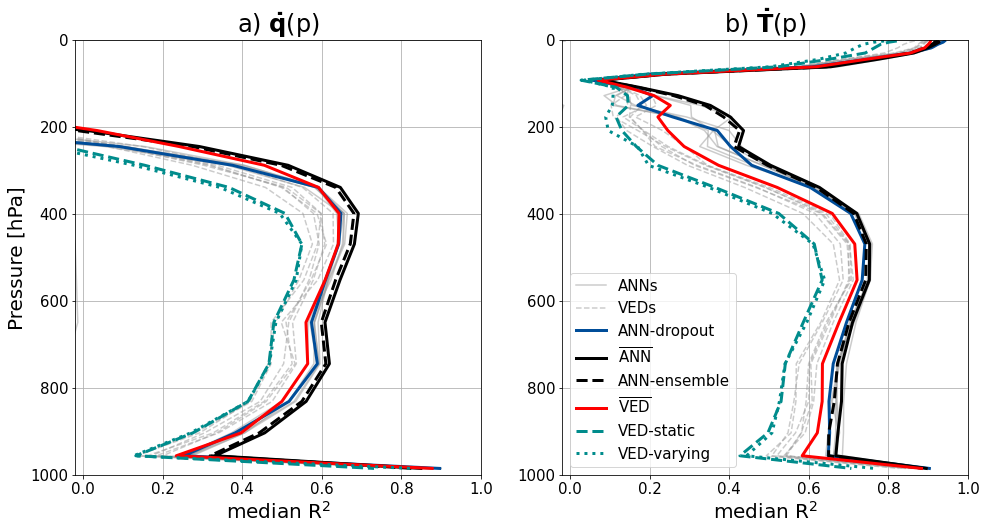

In [17]:
plt.figure(1,(16,8))
plt.subplot(1,2,1)


plt.plot(np.nanmedian(ANN_1_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(VED_7_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,0:26],0),P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1$_{median}$ 7mem dr=0.01')
plt.plot(np.nanmedian(deter_7_lin[:,0:26],0),P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs$_{median}$')
plt.plot(np.nanmedian(stoch_5_lin[:,0:26],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs$_{median}$')
plt.plot(np.nanmedian(VED_deter_6[:,0:26],0),P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs$_{median}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,0:26],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1$_{median}$ $\alpha=0.5$ 7 draws')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,0:26],0),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1$_{median}$ $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median R$^2$',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$(p)',fontsize=24)



plt.subplot(1,2,2)


plt.plot(np.nanmedian(ANN_1_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label='ANNs')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])


plt.plot(np.nanmedian(VED_1_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VEDs')
plt.plot(np.nanmedian(VED_2_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(VED_3_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(VED_4_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(VED_5_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(VED_7_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])




plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,26:52],0),P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(deter_7_lin[:,26:52],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{ANN}}$')
plt.plot(np.nanmedian(stoch_5_lin[:,26:52],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(VED_deter_6[:,26:52],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,26:52],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,26:52],0),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')



sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel(r'median R$^2$',fontsize=20)
plt.title(r'b) $\mathbf{\dot{{T}}}$(p)',fontsize=24)

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Text(0.5, 1.0, 'b) $\\mathbf{\\dot{{T}}}$(p)')

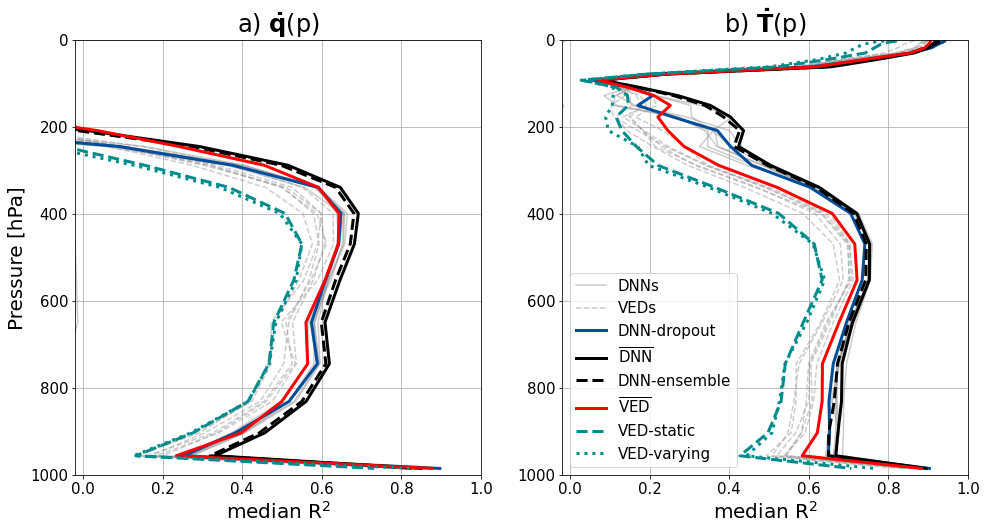

In [10]:
plt.figure(1,(16,8))
plt.subplot(1,2,1)


plt.plot(np.nanmedian(ANN_1_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(VED_7_r_2[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,0:26],0),P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1$_{median}$ 7mem dr=0.01')
plt.plot(np.nanmedian(deter_7_lin[:,0:26],0),P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs$_{median}$')
plt.plot(np.nanmedian(stoch_5_lin[:,0:26],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs$_{median}$')
plt.plot(np.nanmedian(VED_deter_6[:,0:26],0),P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs$_{median}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,0:26],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1$_{median}$ $\alpha=0.5$ 7 draws')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,0:26],0),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1$_{median}$ $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median R$^2$',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$(p)',fontsize=24)



plt.subplot(1,2,2)


plt.plot(np.nanmedian(ANN_1_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label='DNNs')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])


plt.plot(np.nanmedian(VED_1_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VEDs')
plt.plot(np.nanmedian(VED_2_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(VED_3_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(VED_4_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(VED_5_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])
plt.plot(np.nanmedian(VED_7_r_2[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])




plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,26:52],0),P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'DNN-dropout')
plt.plot(np.nanmedian(deter_7_lin[:,26:52],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{DNN}}$')
plt.plot(np.nanmedian(stoch_5_lin[:,26:52],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'DNN-ensemble')
plt.plot(np.nanmedian(VED_deter_6[:,26:52],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,26:52],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,26:52],0),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')



sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel(r'median R$^2$',fontsize=20)
plt.title(r'b) $\mathbf{\dot{{T}}}$(p)',fontsize=24)

Text(0.5, 1.0, 'b) $\\mathbf{\\dot{q}_{ci}}$(p)')

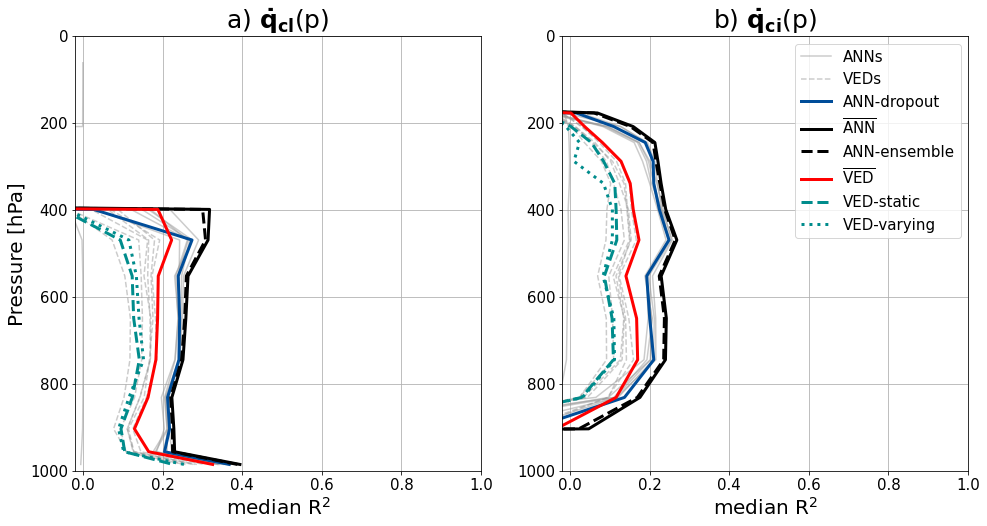

In [18]:
plt.figure(1,(16,8))


plt.subplot(1,2,1)


plt.plot(np.nanmedian(ANN_1_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(VED_7_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,52:78],0),P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1$_{median}$ 7mem dr=0.01')
plt.plot(np.nanmedian(deter_7_lin[:,52:78],0),P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs$_{median}$')
plt.plot(np.nanmedian(stoch_5_lin[:,52:78],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs$_{median}$')
plt.plot(np.nanmedian(VED_deter_6[:,52:78],0),P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs$_{median}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,52:78],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1$_{median}$ $\alpha=0.5$ 7 draws')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,52:78],0),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1$_{median}$ $\alpha$ array 7 draws')



sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median R$^2$',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=25)

plt.subplot(1,2,2)


plt.plot(np.nanmedian(ANN_1_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label='ANNs')#,label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label='VEDs')#,label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 5$_{median}$')
#plt.plot(np.nanmedian(VED_6_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 6$_{median}$')
plt.plot(np.nanmedian(VED_7_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 7$_{median}$')



plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,78:104],0),P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(deter_7_lin[:,78:104],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{ANN}}$')
plt.plot(np.nanmedian(stoch_5_lin[:,78:104],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(VED_deter_6[:,78:104],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,78:104],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,78:104],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')




sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median R$^2$',fontsize=20)
plt.title(r'b) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=25)

Text(0.5, 1.0, 'b) $\\mathbf{\\dot{q}_{ci}}$(p)')

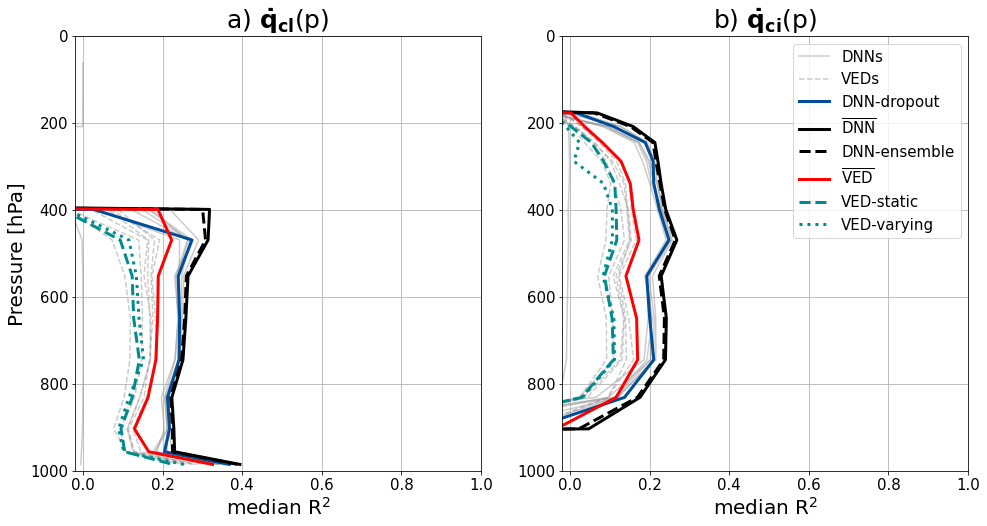

In [11]:
plt.figure(1,(16,8))


plt.subplot(1,2,1)


plt.plot(np.nanmedian(ANN_1_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(VED_7_r_2[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,52:78],0),P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1$_{median}$ 7mem dr=0.01')
plt.plot(np.nanmedian(deter_7_lin[:,52:78],0),P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs$_{median}$')
plt.plot(np.nanmedian(stoch_5_lin[:,52:78],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs$_{median}$')
plt.plot(np.nanmedian(VED_deter_6[:,52:78],0),P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs$_{median}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,52:78],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1$_{median}$ $\alpha=0.5$ 7 draws')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,52:78],0),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1$_{median}$ $\alpha$ array 7 draws')



sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median R$^2$',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=25)

plt.subplot(1,2,2)


plt.plot(np.nanmedian(ANN_1_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label='DNNs')#,label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label='VEDs')#,label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 5$_{median}$')
#plt.plot(np.nanmedian(VED_6_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 6$_{median}$')
plt.plot(np.nanmedian(VED_7_r_2[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 7$_{median}$')



plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,78:104],0),P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'DNN-dropout')
plt.plot(np.nanmedian(deter_7_lin[:,78:104],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{DNN}}$')
plt.plot(np.nanmedian(stoch_5_lin[:,78:104],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'DNN-ensemble')
plt.plot(np.nanmedian(VED_deter_6[:,78:104],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,78:104],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,78:104],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')




sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median R$^2$',fontsize=20)
plt.title(r'b) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=25)

In [12]:
SP_2D_VAR_updt=[r'Snow$_{CRM}$','Prec$_{CRM}$',r'Q$_{lw \ surf}$',
           r'Q$_{sw \ surf}$',r'Q$_{sol \ lw}$',r'Q$_{sol \ lw, \ diff}$',
           r'Q$_{sol \ sw}$',r'Q$_{sol \ sw, \ diff}$']

Text(0.5, 1.0, '2D SPCESM variables')

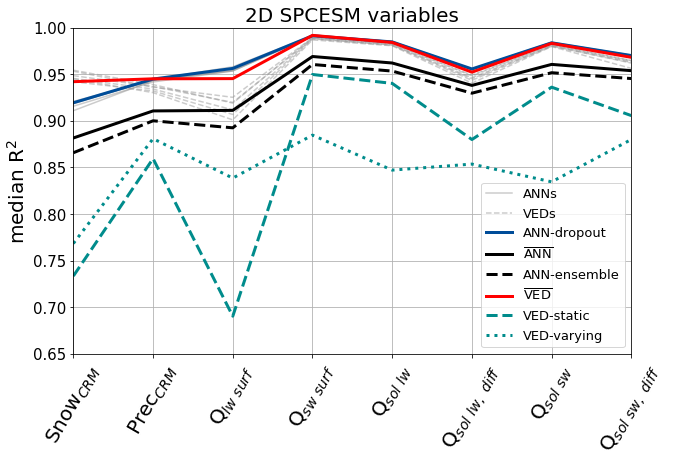

In [21]:
plt.figure(2,(10,6))

plt.plot(np.nanmedian(ANN_1_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5],label='ANNs')#,label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5],label='VEDs')#,label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(VED_7_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 7$_{median}$')



plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,104:112],0),linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(deter_7_lin[:,104:112],0),linewidth=3,color='k',label=r'$\overline{\mathrm{ANN}}$')
plt.plot(np.nanmedian(stoch_5_lin[:,104:112],0),'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(VED_deter_6[:,105:113],0),linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,105:113],0),'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,105:113],0),':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')






plt.grid(True)
plt.ylim(0.65,1)
plt.xlim(0,7)
plt.legend(fontsize=13,loc=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(ANN_1_lin_r_2[1,104:112].size),SP_2D_VAR_updt, rotation=60,fontsize=20)

plt.ylabel(r'median R$^2$',fontsize=20)
plt.title('2D SPCESM variables',fontsize=20)



Text(0.5, 1.0, '2D SPCESM variables')

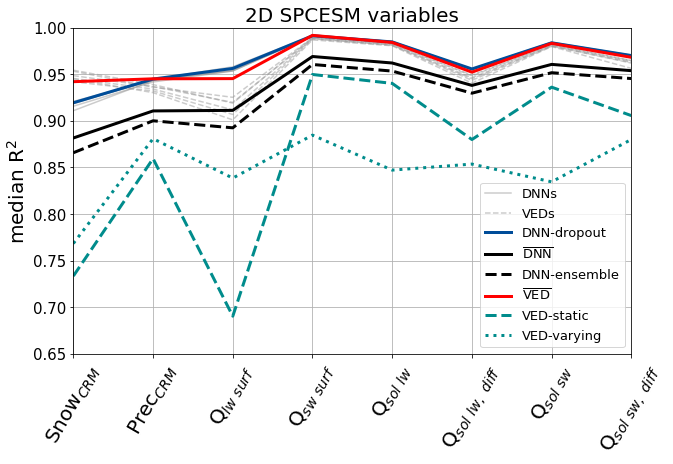

In [13]:
plt.figure(2,(10,6))

plt.plot(np.nanmedian(ANN_1_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5],label='DNNs')#,label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_r_2[:,104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5],label='VEDs')#,label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(VED_7_r_2[:,105:113],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 7$_{median}$')



plt.plot(np.nanmedian(ANN_1_lin_dr_01_R2_7_mem[:,104:112],0),linewidth=3,color=[0,0.3,0.6],label=r'DNN-dropout')
plt.plot(np.nanmedian(deter_7_lin[:,104:112],0),linewidth=3,color='k',label=r'$\overline{\mathrm{DNN}}$')
plt.plot(np.nanmedian(stoch_5_lin[:,104:112],0),'--',linewidth=3,color='k',label=r'DNN-ensemble')
plt.plot(np.nanmedian(VED_deter_6[:,105:113],0),linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(VED_1_7_0_5[:,105:113],0),'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(VED_1_7_alpha_1_R2[:,105:113],0),':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')






plt.grid(True)
plt.ylim(0.65,1)
plt.xlim(0,7)
plt.legend(fontsize=13,loc=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(ANN_1_lin_r_2[1,104:112].size),SP_2D_VAR_updt, rotation=60,fontsize=20)

plt.ylabel(r'median R$^2$',fontsize=20)
plt.title('2D SPCESM variables',fontsize=20)



In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib.image as imag

In [15]:
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import math

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [16]:
lat=np.arange(-90,90,180/96)
lon=np.arange(0,360,360/144)

In [17]:
fz = 18
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw


In [18]:
vmin0 = 0.0
vmax0 = 1

In [19]:
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
def color_map_personalizer(Number_of_Colors,vmin__,vmax__,colorscale):
    
    cmap = mpl.colormaps[colorscale]
    # extract all colors from the .seismic map
    cmaplist = [cmap(i) for i in np.arange(cmap.N)]
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = np.linspace(vmin__, vmax__, Number_of_Colors)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cmap , norm

In [20]:
seism_,norm_seism=color_map_personalizer(21,vmin0,vmax0,'Blues')

In [21]:
vmin_diff_2=-1; vmax_diff_2=1
diff_2,norm_diff_2=color_map_personalizer(21,vmin_diff_2,vmax_diff_2,'RdBu')


0
0
1
1
0
1


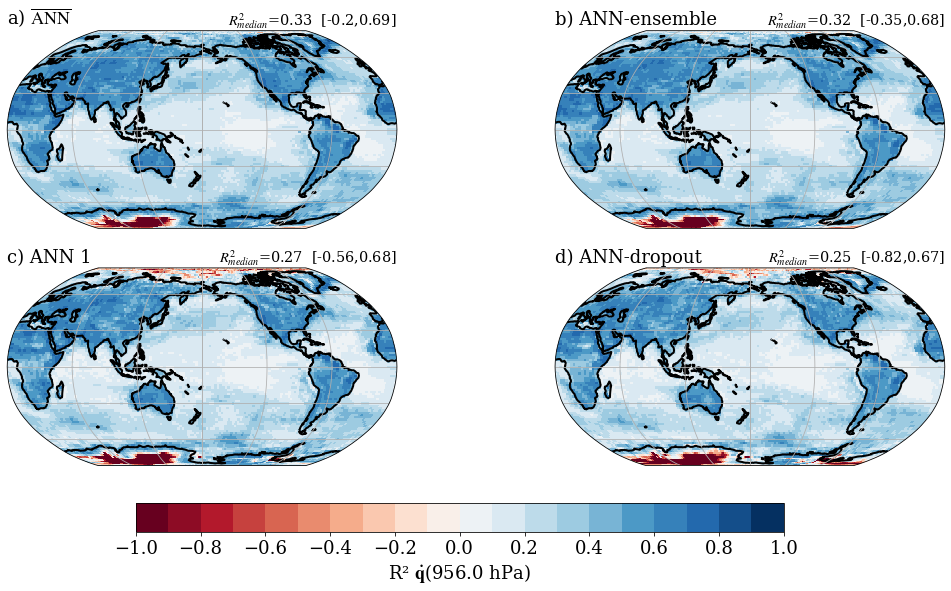

In [30]:
fig, ax = plt.subplots(2,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(18,8))

for isub in range(0,2): # Loop over 4 subplots
    #print(isub)
    isub0 = isub-2*math.floor(isub/2) # Determine location of subplot (out of 4)
    print(isub0)
    for iax in range(2): 
        
        if iax==0: 
            
            if isub0==0: 
                data = np.reshape(deter_7_lin[:,24],(lat.size,lon.size));
                tit = r'a) $\overline{\mathrm{ANN}}$';
                tit_2=r'$R^2_{median}$='+ str(np.round(np.median(deter_7_lin[:,24])
                                                                ,2))+'  ['+str(np.round(np.percentile(deter_7_lin[:,24]
                                                                                                      ,2.5),2))+','+str(np.round(np.percentile(deter_7_lin[:,24],97.5),2))+']';

            if isub0==1:
                data = np.reshape(stoch_5_lin[:,24],(lat.size,lon.size));
                tit = r'b) ANN-ensemble';
                tit_2=r'$R^2_{median}$='+ str(np.round(np.median(stoch_5_lin[:,24])
                                                                ,2))+'  ['+str(np.round(np.percentile(stoch_5_lin[:,24],
                                                                                                      2.5),2))+','+str(np.round(np.percentile(stoch_5_lin[:,24],97.5),2))+']';


                
        if iax==1: 
            
            if isub0==0:
                data = np.reshape(ANN_1_lin_r_2[:,24],(lat.size,lon.size));
                tit = r'c) ANN 1';
                tit_2=r'$R^2_{median}$='+ str(np.round(np.median(ANN_1_lin_r_2[:,24])
                                                                ,2))+'  ['+str(np.round(np.percentile(ANN_1_lin_r_2[:,24],
                                                                                                      2.5),2))+','+str(np.round(np.percentile(ANN_1_lin_r_2[:,24],97.5),2))+']';


                
            if isub0==1:
                data = np.reshape(ANN_1_lin_dr_01_R2_7_mem[:,24],(lat.size,lon.size));
                tit = r'd) ANN-dropout';
                tit_2=r'$R^2_{median}$='+ str(np.round(np.median(ANN_1_lin_dr_01_R2_7_mem[:,24])
                                                                ,2))+'  ['+str(np.round(np.percentile(ANN_1_lin_dr_01_R2_7_mem[:,24]
                                                                                                      ,2.5),2))+','+str(np.round(np.percentile(ANN_1_lin_dr_01_R2_7_mem[:,24]
                                                                                                                                               ,97.5),2))+']';

                
        iax7 = iax+2*math.floor(isub/2) # To make 6 panels 
        print(iax7)
        imag = ax[iax7][isub0].pcolormesh(lon, lat, data,
                                cmap=diff_2,norm=norm_diff_2, 
                                transform=ccrs.PlateCarree())
        ax[iax7][isub].coastlines(color='black',linewidth=2)
        ax[iax7][isub].gridlines()
        ax[iax7][isub].set_title(tit,loc='left',fontsize=fz)
        ax[iax7][isub].set_title(tit_2,loc='right',fontsize=fz*0.8)

             
            
         
        if isub==1 and iax==1:
            cbar_ax = fig.add_axes([0.25, 0.01, 0.50, 0.05])
            cb=fig.colorbar(imag, label="R² $\mathbf{\dot{q}}$("+str(np.round(P[24].values/100,0)) +" hPa)", cax=cbar_ax,ticks=np.arange(-1,1.01,2E-1),orientation='horizontal')
      

0
0
1
1
0
1


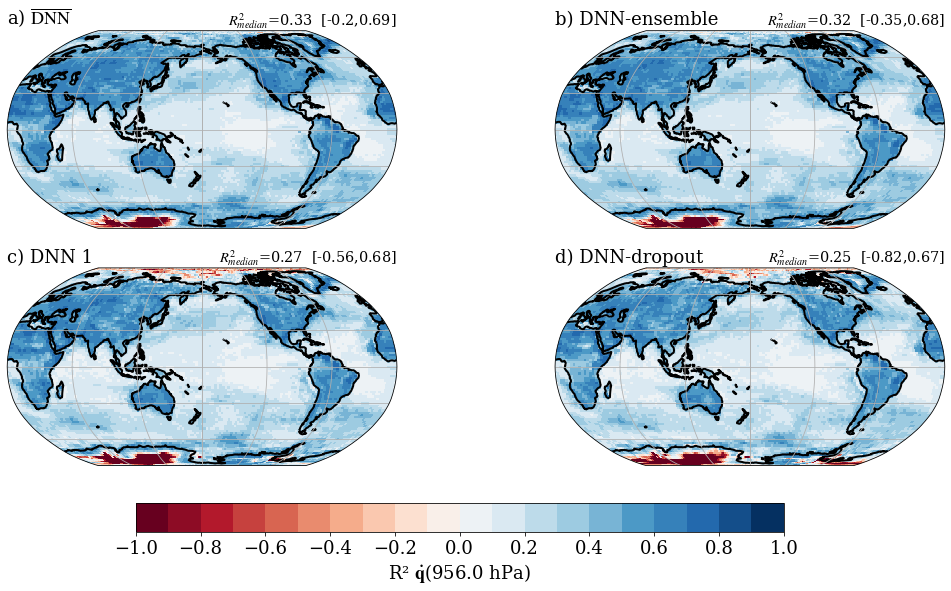

In [22]:
fig, ax = plt.subplots(2,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(18,8))

for isub in range(0,2): # Loop over 4 subplots
    #print(isub)
    isub0 = isub-2*math.floor(isub/2) # Determine location of subplot (out of 4)
    print(isub0)
    for iax in range(2): 
        
        if iax==0: 
            
            if isub0==0: 
                data = np.reshape(deter_7_lin[:,24],(lat.size,lon.size));
                tit = r'a) $\overline{\mathrm{DNN}}$';
                tit_2=r'$R^2_{median}$='+ str(np.round(np.median(deter_7_lin[:,24])
                                                                ,2))+'  ['+str(np.round(np.percentile(deter_7_lin[:,24]
                                                                                                      ,2.5),2))+','+str(np.round(np.percentile(deter_7_lin[:,24],97.5),2))+']';

            if isub0==1:
                data = np.reshape(stoch_5_lin[:,24],(lat.size,lon.size));
                tit = r'b) DNN-ensemble';
                tit_2=r'$R^2_{median}$='+ str(np.round(np.median(stoch_5_lin[:,24])
                                                                ,2))+'  ['+str(np.round(np.percentile(stoch_5_lin[:,24],
                                                                                                      2.5),2))+','+str(np.round(np.percentile(stoch_5_lin[:,24],97.5),2))+']';


                
        if iax==1: 
            
            if isub0==0:
                data = np.reshape(ANN_1_lin_r_2[:,24],(lat.size,lon.size));
                tit = r'c) DNN 1';
                tit_2=r'$R^2_{median}$='+ str(np.round(np.median(ANN_1_lin_r_2[:,24])
                                                                ,2))+'  ['+str(np.round(np.percentile(ANN_1_lin_r_2[:,24],
                                                                                                      2.5),2))+','+str(np.round(np.percentile(ANN_1_lin_r_2[:,24],97.5),2))+']';


                
            if isub0==1:
                data = np.reshape(ANN_1_lin_dr_01_R2_7_mem[:,24],(lat.size,lon.size));
                tit = r'd) DNN-dropout';
                tit_2=r'$R^2_{median}$='+ str(np.round(np.median(ANN_1_lin_dr_01_R2_7_mem[:,24])
                                                                ,2))+'  ['+str(np.round(np.percentile(ANN_1_lin_dr_01_R2_7_mem[:,24]
                                                                                                      ,2.5),2))+','+str(np.round(np.percentile(ANN_1_lin_dr_01_R2_7_mem[:,24]
                                                                                                                                               ,97.5),2))+']';

                
        iax7 = iax+2*math.floor(isub/2) # To make 6 panels 
        print(iax7)
        imag = ax[iax7][isub0].pcolormesh(lon, lat, data,
                                cmap=diff_2,norm=norm_diff_2, 
                                transform=ccrs.PlateCarree())
        ax[iax7][isub].coastlines(color='black',linewidth=2)
        ax[iax7][isub].gridlines()
        ax[iax7][isub].set_title(tit,loc='left',fontsize=fz)
        ax[iax7][isub].set_title(tit_2,loc='right',fontsize=fz*0.8)

             
            
         
        if isub==1 and iax==1:
            cbar_ax = fig.add_axes([0.25, 0.01, 0.50, 0.05])
            cb=fig.colorbar(imag, label="R² $\mathbf{\dot{q}}$("+str(np.round(P[24].values/100,0)) +" hPa)", cax=cbar_ax,ticks=np.arange(-1,1.01,2E-1),orientation='horizontal')
      